In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from utils import get_data_per_anchor, spatial_plot
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import os
import warnings
from micromlgen import port
import m2cgen as m2c
warnings.filterwarnings("ignore")

In [2]:
params = {
    "test_size":0.33,
    "random_state":42,
    "splits":3,
    
}

In [3]:
df = pd.read_pickle("raw_IQ.pkl")
df.sort_values(['point', 'anchor', 'room', 'channel'], inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
def iq_processing(data):
    
    """
    Input: Data
    Output: Processed Data

    Processing: Power Scaling, IQ shifting
    """

    cols_real = ['pdda_input_real_{}'.format(x+1) for x in range(5)]
    cols_imag = ['pdda_input_imag_{}'.format(x+1) for x in range(5)]

    iq_values = pd.DataFrame(data['pdda_input_real'].tolist(), columns=cols_real, index=data.index)
    iq_values[cols_imag] = pd.DataFrame(data['pdda_input_imag'].tolist(), columns=cols_imag, index=data.index)
    
    phase = pd.DataFrame(np.arctan2(iq_values['pdda_input_imag_1'],iq_values['pdda_input_real_1']), columns=['phase_1'])
    
    cos = np.cos(phase).values.ravel()
    sin = np.sin(phase).values.ravel()
    
    out = data.copy()
    iq_ref = np.abs(iq_values[f'pdda_input_real_1']*cos + iq_values[f'pdda_input_imag_1']*sin)
    for i in range(1,6):
        out[f'pdda_input_real_{i}'] = (iq_values[f'pdda_input_real_{i}']*cos + iq_values[f'pdda_input_imag_{i}']*sin)
        out[f'pdda_input_imag_{i}'] = (-iq_values[f'pdda_input_real_{i}']*sin + iq_values[f'pdda_input_imag_{i}']*cos)
        iq_ref +=  iq_values[f'pdda_input_real_{i}']**2 + iq_values[f'pdda_input_imag_{i}']**2

    power_norm =  StandardScaler().fit_transform((out['reference_power'] + out['relative_power']).values.reshape(-1,1))/10
    
    out.insert(25, 'power', power_norm)
    out.insert(24, 'iq_ref', iq_ref)
    out.drop(columns=['pdda_input_imag_1', 'pdda_input_real', 'pdda_input_imag'], inplace=True)
    return out

In [5]:
features = ['power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4',
           'pdda_input_real_5', 'pdda_input_imag_5']
# theta does not change, make predictions for phi only, azimuth angles 
# predict only for phi, 
targets = ['true_phi']
location = ['x_tag', 'y_tag']
pdda_angle = ['pdda_phi']
point = ['point']

In [6]:
def scale(df):
    """scale dataset with mean=0, std=1"""
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

In [7]:
def select_polarity(df):
    """"rssi signals closer to 0, represent the better quality of signal"""
    tmp = df.sort_values(['point', 'anchor', 'channel', 'room'])
    tmp['mask'] = tmp['reference_power'] + df['relative_power']
    tmp = tmp.sort_values(['point', 'anchor', 'channel', 'room', 'mask'])
    tmp = tmp.drop_duplicates(subset=['point', 'anchor', 'channel', 'room'], keep='last')
    return tmp

In [8]:
def select_random_channel(df):
    mid_concrete_random = pd.DataFrame()
    for room in df.room.unique():
        room_df = df.loc[df['room'] == room]
        for anchor in df.anchor.unique():
            anchor_df = room_df.loc[room_df['anchor'] == anchor]
            grouped = anchor_df.groupby(['point'],as_index=False)
            for group, tdf in grouped:
                random_selection = tdf.sample(n=1,random_state=42)
                mid_concrete_random = pd.concat([mid_concrete_random, random_selection])
    return mid_concrete_random

In [9]:
def train(df, models, metrics):
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    anchor_val = []
    x_loc = []
    y_loc = []
    pts = []
    flag = True
    trained_models = {}
    anchor_mae = {}
    pdda_error = []
    m_preds = {}
    for model in models:
        print(str(model))
        for anchor in [1.0,2.0,3.0,4.0]:
            avg_mae = 0
            avg_pdda = 0
            anchor_df = df.loc[df['anchor'] == anchor]
            X = anchor_df[features].values
            y = anchor_df[targets].values
            gss = GroupShuffleSplit(n_splits=params["splits"], test_size=params["test_size"], random_state=params["random_state"])
            fold = 1
            for train_idx, test_idx in gss.split(X, y, groups=anchor_df.point):
                temp = pd.DataFrame()
                train = anchor_df.iloc[train_idx]
                test = anchor_df.iloc[test_idx]
                assert round(test.shape[0]/(train.shape[0]+test.shape[0]), 2) == params["test_size"]
                assert len(set(train.point) & set(test.point)) == 0
                X_train = train[features].values
                y_train = train[targets].values
                X_test = test[features].values
                test_location = test[location].values
                pdda_result = test[pdda_angle].values
                y_test = test[targets].values
                points = test[point].values
                

                # learn the trainer on the train set and apply for testing set
                regr = model
                regr.fit(X_train,y_train)
                if str(model) not in trained_models:
                    if str(model).split("(")[0] != "XGBRegressor":
                        trained_models[str(model)] = regr
                    else:
                        trained_models["XGBRegressor"] = regr
                # trained_models.append(regr)
                predictions = regr.predict(X_test)
                # print(predictions)
    
                # need pointwise error for plotting using spatial_plot function
                for i in range(len(predictions)):
                    model_preds.append(predictions[i])
                    # predictions.append(mean_absolute_error(y_test[i], temp))
                    pdda_preds.append(pdda_result[i][0])
                    true_phi.append(y_test[i][0])
                    pts.append(points[i][0])
                    x_coordinate, y_coordinate = test_location[i]
                    x_loc.append(x_coordinate)
                    y_loc.append(y_coordinate)
                    anchor_val.append(anchor)
                l_mae = mean_absolute_error(y_test.ravel(), predictions.ravel())
                pdda_mae = mean_absolute_error(y_test.ravel(), pdda_result.ravel())
                avg_mae += l_mae
                avg_pdda += pdda_mae
               
        
                # print(avg_mae)
            avg_mae = avg_mae/3
            avg_pdda = avg_pdda/3
            # print(avg_mae)
            if len(pdda_error) < 4:
                pdda_error.append(avg_pdda)
            model_name = str(model).split("(")[0]
            if model_name != 'XGBRegressor':
                model_name = str(model)
            if str(model_name) not in anchor_mae:
                anchor_mae[model_name] = [avg_mae]
            else:
                anchor_mae[model_name] += [avg_mae]
            # avg_mae.append(sum(errors)/len(errors))
            # temp = []

        
        
        # model_name = str(model).split("(")[0]
        # if model_name == 'XGBRegressor':
        #     results[model_name] = model_preds
        # else:
        #     results[str(model)] = model_preds
         
        if flag:
            temp['pdda'] = pdda_preds
            temp['true_phi'] = true_phi
            temp['x_loc'] = x_loc
            temp['y_loc'] = y_loc
            temp['point'] = pts
            temp['anchor'] = anchor_val
            results = pd.concat([results, temp])
            flag = False
            
        model_name = str(model).split("(")[0]
        if model_name != 'XGBRegressor':
            model_name = str(model)
        m_preds[model_name] = model_preds
        model_preds = []
        pdda_preds = []
        true_phi = []
        x_loc = []
        y_loc = []
        pts = []
        anchor_val = []
        # results = pd.concat([results, temp])
    for k,v in m_preds.items():
        results[k] = v
    return (results, anchor_mae, pdda_error, trained_models)

In [10]:
def calculate_mae_errors(results):
    # calculate average mae errors over all anchors
    grouped = results.groupby(['point','anchor'],as_index=False)
    avg_errors = pd.DataFrame()

    for group, tdf in grouped:
        p_df = pd.DataFrame()
        maes_pdda = []
        maes_rf100 = []
        maes_rf10 = []
        maes_svr = []
        maes_lr = []
        
        maes_xgboost = []
        maes_dt = []
        x_locs = []
        y_locs = []
        maes_pdda.append(mean_absolute_error([np.mean(tdf['pdda'].values)], [tdf['true_phi'].values[0]]))

        maes_rf100.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor()'].values)], [tdf['true_phi'].values[0]]))
        maes_rf10.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor(n_estimators=10)'].values)], [tdf['true_phi'].values[0]]))
        maes_svr.append(mean_absolute_error([np.mean(tdf['SVR()'].values)], [tdf['true_phi'].values[0]]))
        maes_xgboost.append(mean_absolute_error([np.mean(tdf['XGBRegressor'].values)], [tdf['true_phi'].values[0]]))
        maes_dt.append(mean_absolute_error([np.mean(tdf['DecisionTreeRegressor()'].values)], [tdf['true_phi'].values[0]]))
        maes_lr.append(mean_absolute_error([np.mean(tdf['LinearRegression()'].values)], [tdf['true_phi'].values[0]]))
        x_locs.append(tdf['x_loc'].values[0])
        y_locs.append(tdf['y_loc'].values[0])

        p_df['MAE_pdda'] = maes_pdda
        p_df['MAE_LR'] = maes_lr
        p_df['MAE_SVR'] = maes_svr
        p_df['MAE_DT'] = maes_dt
        
        p_df['MAE_RF10'] = maes_rf10
        
        p_df['MAE_XGBoost'] = maes_xgboost

        p_df['MAE_RF100'] = maes_rf100
        p_df['x_loc'] = x_locs
        p_df['y_loc'] = y_locs

        avg_errors = pd.concat([avg_errors, p_df])
    return avg_errors
            


In [47]:
dump_list = trained_models['XGBRegressor'].get_booster().get_dump()
num_trees = len(dump_list)

In [48]:
num_trees

100

In [43]:
booster = trained_models['XGBRegressor'].get_booster().num_round
tree_df = booster.trees_to_dataframe()
# tree_df[tree_df['Tree'] == 0]

In [44]:
import json
def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    return max(list(item_generator(json_input, 'depth'))) + 1

[tree_depth(x) for x in booster.get_dump(dump_format = "json")]

[6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

In [42]:
trained_models['DecisionTreeRegressor()'].tree_.max_depth

28

In [41]:
avg_tree_depth = 0
count = 0
total = 0
for estimator in trained_models['RandomForestRegressor()'].estimators_:
    count += 1
    total += estimator.tree_.max_depth
total/count

26.42

In [22]:
trained_models['RandomForestRegressor()'].get_depth()

AttributeError: 'SVR' object has no attribute 'get_depth'

In [37]:
def all_environments():
    rooms = ['testbench_01', 'testbench_01_furniture_low', 'testbench_01_furniture_mid', 'testbench_01_furniture_high']
    aoanet= [4.831005,4.991831,5.408162,5.551577]
    result = pd.DataFrame()
    i = 0
    for room in rooms:
        environment = df[df['room'] == room]
        environment = iq_processing(environment)
        environment = scale(environment)
        environment = select_polarity(environment)
        environment = select_random_channel(environment)

        results, anchor_mae, pdda_error, trained_models = train(environment, models, metrics)

        avg_errors = calculate_mae_errors(results)

        col_names = ['MAE_pdda','MAE_LR', 'MAE_SVR', 'MAE_DT', 'MAE_RF10', 'MAE_XGBoost', 'MAE_RF100']
        model_names = ['pdda', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100', 'aoanet']

        result.index = model_names
        errors = list(avg_errors[col_names].mean().values)
        errors.append(aoanet[i])
        result[room] = errors
        i += 1
    return result,trained_models
    

In [38]:
models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10), DecisionTreeRegressor(), SVR(), xgb.XGBRegressor(), LinearRegression()]
metrics = [mean_absolute_error, r2_score]
# models = [DecisionTreeRegressor()]

In [39]:
result,trained_models = all_environments()

RandomForestRegressor()
RandomForestRegressor(n_estimators=10)
DecisionTreeRegressor()
SVR()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
LinearRegression()
RandomForestRegressor()
RandomForestRegressor(n_estimators=10)
DecisionTreeRegressor()
SVR()
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
  

In [32]:
def stripplot():
    # aoanet= [4.831005,4.991831,5.408162,5.551577]
    # result = pd.read_pickle('results/figure3_panel1.pkl')
    # result = all_environments()
    
    model_names = ['pdda', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100']
    subset = result.loc[model_names]
    df_melted = subset.reset_index().melt(id_vars='index')
    df_melted = df_melted.rename(columns={'index': 'Model', 'value': 'MAE', 'variable':'Environment'})

    # figure 3
    data = result.loc[model_names]
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15,8))
    ax = sns.stripplot(data=df_melted, x='Model', y='MAE', hue='Environment')
    ax.set_ylim([4,10])
    plt.savefig('figures/Figure3/panel2/models_all_channel_stripplot')
    plt.savefig('figures/Figure3/panel2/models_all_channel_stripplot.pdf', bbox_inches='tight')

    plt.show()

In [4]:
result = pd.read_pickle('results/figure3_panel1.pkl')
result.head(10)

,testbench_01,testbench_01_furniture_low,testbench_01_furniture_mid,testbench_01_furniture_high
pdda,8.543385,8.432292,9.389305,8.860607
Linear Regression,9.412078,9.568003,9.844010,10.268760
SVR,8.547875,8.643641,8.761621,9.003906
Decision Tree,6.882543,7.261287,7.606070,7.617472
RF10,5.611666,5.740991,6.253664,6.183317
XGBoost,5.643571,5.838038,6.218492,6.293050
RF100,5.413609,5.568117,5.972842,5.890732
aoanet,4.831005,4.991831,5.408162,5.551577
Modified aoanet,4.895520,5.168705,5.537297,5.588882


In [7]:
# result.describe()

In [5]:
result_multi = pd.read_pickle('results/multichannel.pkl')
result_multi.head(10)

,testbench_01,testbench_01_furniture_low,testbench_01_furniture_mid,testbench_01_furniture_high
pdda,8.543385,8.432292,9.389305,8.860607
Linear Regression,8.115068,8.248080,8.567222,8.876190
SVR,7.706830,7.910116,8.089682,8.240463
Decision Tree,5.853511,6.228757,6.700604,6.338072
RF10,4.590026,4.736983,5.228569,5.077510
XGBoost,4.356679,4.596597,5.045069,4.975150
RF100,4.269348,4.482749,4.900093,4.781841
Modified AoANet,4.895520,5.168705,5.537297,5.588882
AoANet,4.831005,4.991831,5.408162,5.551577


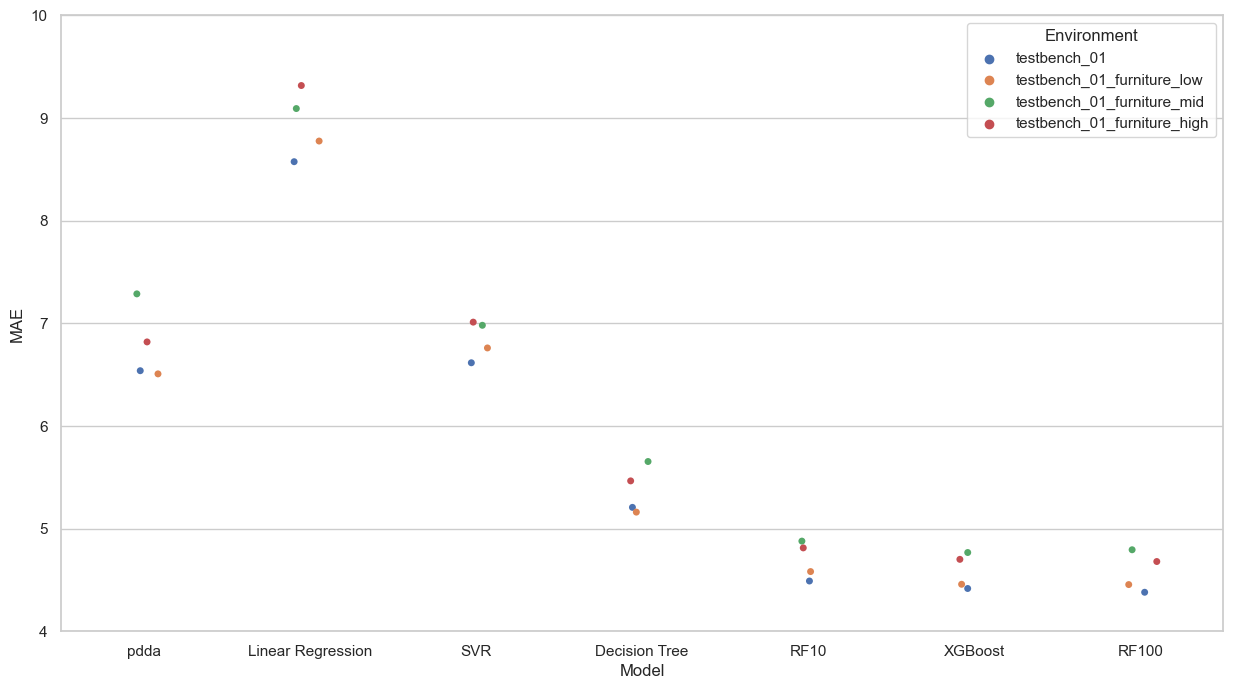

In [33]:
stripplot()